# Лабораторная работа 3

### Цель: предсказывать факт выживания на корабле Титаник
### Задачи

* Обучить логистическую регрессию, подобрать параметры
* Сравним результаты L1, L2, оценить веса признаков
* Провести отбор признаков с помощью L1 регуляризации, подобрать оптимальный С, объяcнить результат

Загрузим данные из ЛР 2 и поменяем целевой параметр. (Заменяем факт выживания на цену билета)

In [1]:
#импорт необходимых модулей
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams

# результат по выживани.
trainSurvivedPath = '/home/alex/Downloads/bmstuML/dataMl/trainSurvived.plk'
testSurvivedPath = '/home/alex/Downloads/bmstuML/dataMl/testSurvived.plk'

y_train = pd.read_pickle(trainSurvivedPath)
y_test = pd.read_pickle(testSurvivedPath)


# подготовленные данные из ЛР 2
trainDataPath = '/home/alex/Downloads/bmstuML/dataMl/trainData.plk'
testDataPath = '/home/alex/Downloads/bmstuML/dataMl/testData.plk'

X_train = pd.read_pickle(trainDataPath)
X_test = pd.read_pickle(testDataPath)

# теперь цель - это цена, а не выживание
# X_train['Survived'] = y_train
# X_test['Survived'] = y_test

# y_train = X_train['Fare']
# y_test = X_test['Fare']

# X_train = X_train.drop(['Fare'], axis='columns')
# X_test = X_test.drop(['Fare'], axis='columns')

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sex     714 non-null    float64
 1   Age     714 non-null    float64
 2   SibSp   714 non-null    float64
 3   Parch   714 non-null    float64
 4   Fare    714 non-null    float64
 5   is_S    714 non-null    float64
 6   is_C    714 non-null    float64
 7   is_Q    714 non-null    float64
dtypes: float64(8)
memory usage: 44.8 KB


### Линейная  регрессия
Обучим линейную регрессию и посмотрим результат. Для этого напишем функции: для отрисовки результата, для логистической регрессии без регуляризции, с L1, L2 регуляризции.

In [2]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import recall_score, accuracy_score, precision_score

# функция отрисовки результатов
def showResult(y_Test, test_predict, linear_model, limit):
    
    print('Limit:', limit)
    
    test_predict_bool_result = test_predict.copy()
    test_predict_bool_result[test_predict_bool_result >= limit] = True
    test_predict_bool_result[test_predict_bool_result < limit] = False
    
    test_true_bool_result = y_Test.copy()
    test_true_bool_result[test_true_bool_result >= limit] = True
    test_true_bool_result[test_true_bool_result < limit] = False
    
    
    accur_score = accuracy_score(y_true=y_Test, y_pred=test_predict_bool_result)
    print('Accuracy score:', accur_score)
    
    prec_score = precision_score(y_true=y_Test, y_pred=test_predict_bool_result)
    print('Precision score:', prec_score)
    
    #rec_score = recall_score(y_true=y_Test, y_pred=test_predict_bool_result)
    #print('Recall score:', rec_score)
    
    rcParams['figure.figsize'] = 20,12
    x = np.arange(len(test_predict))
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(x, test_predict, label='model result')
    ax.plot(x, y_Test, label='true result')
    plt.title(linear_model)
    ax.legend()
    plt.show()
    

# без регуляризции    
def linear_reg_Simple(y_dataTrain, dataTrain, y_dataTest, dataTest, limit):    
    reg = LinearRegression(normalize=False) # нормализация уже была в шагах ЛР 2
    reg.fit(dataTrain, y_dataTrain)
    test_score = reg.score(dataTest, y_dataTest)
    y_pred = reg.predict(dataTest)
    print('Score linear_reg_Simple:', test_score);
    print('Weight vector:', reg.coef_)
    showResult(y_dataTest, y_pred, 'linear_reg Simple', limit)
    
# L1    
def linear_reg_Lasso(y_dataTrain, dataTrain, y_dataTest, dataTest, alpha_coef, limit):
    reg = Lasso(alpha=alpha_coef)
    reg.fit(dataTrain, y_dataTrain)    
    test_score = reg.score(dataTest, y_dataTest)    
    print('Score L1 Lasso:', test_score); 
    print('Weight vector:', reg.coef_)
    test_predict = reg.predict(dataTest)     
    showResult(y_dataTest, test_predict, 'linear_reg L1 Lasso', limit)
    
    
# L2    
def linear_reg_Ridge(y_dataTrain, dataTrain, y_dataTest, dataTest, alpha_coef, limit):
    reg = Ridge(alpha=alpha_coef)
    reg.fit(dataTrain, y_dataTrain)    
    test_score = reg.score(dataTest, y_dataTest)    
    print('Score L2 Ridge:', test_score);
    print('Weight vector:', reg.coef_)
    test_predict = reg.predict(dataTest)     
    showResult(y_dataTest, test_predict, 'linear_reg L2 Ridge', limit)
        
        
        

Score linear_reg_Simple: 0.7263678372106703
Weight vector: [-0.52043688 -0.24698209 -0.25962852 -0.16473417  0.84280781 -0.22964303
 -0.12299286 -0.33360824]
Limit: 0.4
Accuracy score: 0.9758308157099698
Precision score: 0.9407407407407408


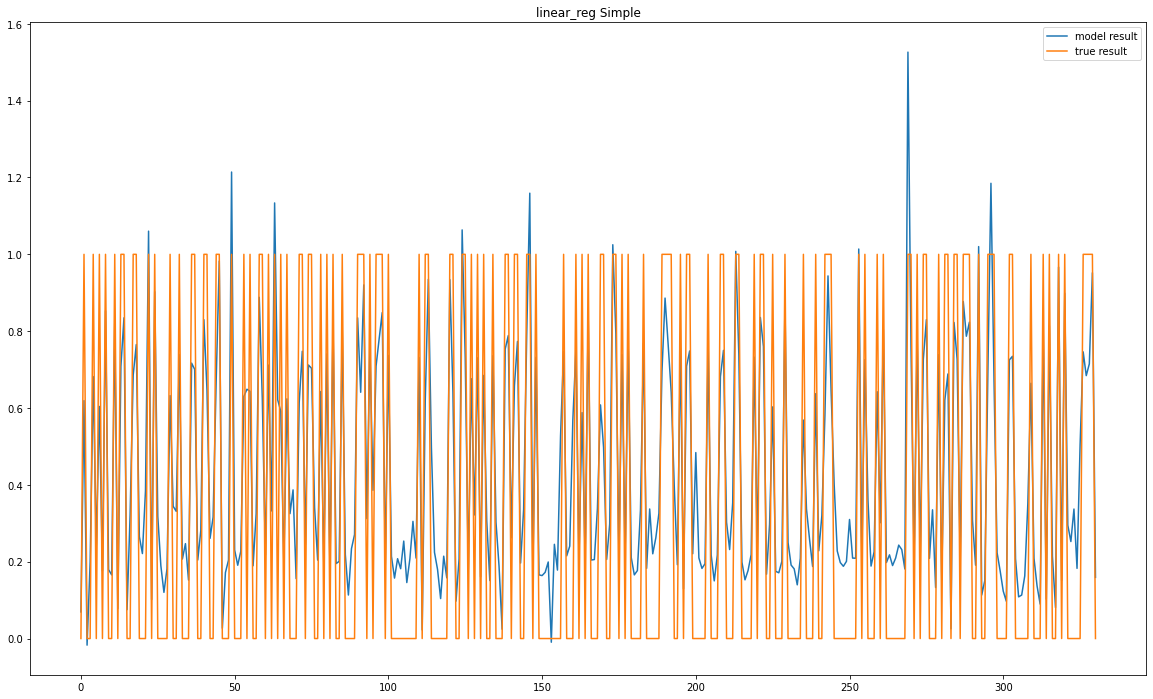

In [3]:
# линейная регрессия без регуляризции
linear_reg_Simple(y_train, X_train, y_test, X_test, 0.4)

Результат 0.726 достаточно неплохой для данного метода и задачи.
Заметим, что нам пришлось самостоятельно добавлять порог, по которому мы будем судить мертвый пассажир или нет.

Также отметим, что мы не получили огромные веса. Так как веса небольшие, то не ожидаем сильной пользы от L1 и L2. (веса небольшие, модель не переобучена, испольузем L1 и L2 для выполнения ТЗ для лабы)

#### Линейная регрессия L1
Будем штрафовать коэффиеценты и складывать с ошибкой. В L1 используется модуль весов.
alfa_coef - умножаем веса на этот коэффиецент. Используется для влияния на вес весов.


Score L1 Lasso: -0.0021364159949219808
Weight vector: [-0. -0. -0.  0.  0. -0.  0. -0.]
Limit: 0.4
Accuracy score: 0.38368580060422963
Precision score: 0.38368580060422963


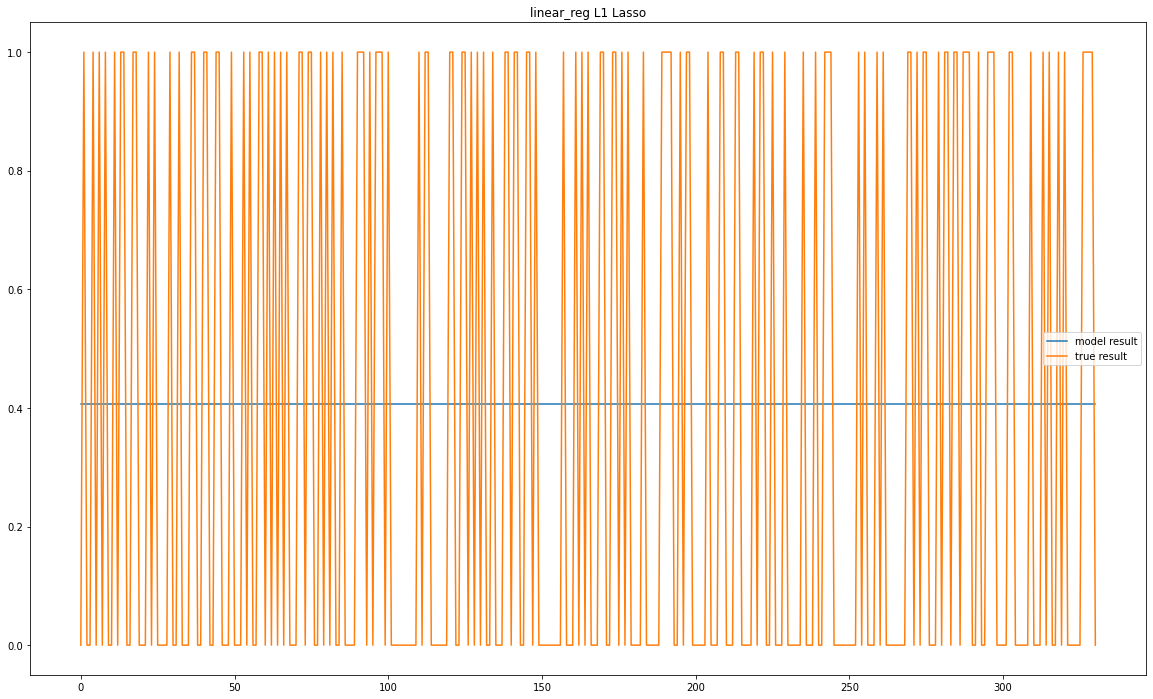

In [4]:
alfa_coef = 3
linear_reg_Lasso(y_train, X_train, y_test, X_test, alfa_coef, 0.4)

#### Линейная регрессия L2
В L2 используется квадрат весов.

Score L2 Ridge: 0.7362733277912983
Weight vector: [-0.51781201 -0.18299523 -0.20908921 -0.10937898  0.56521648 -0.05500351
  0.07227682 -0.14884301]
Limit: 0.4
Accuracy score: 0.9788519637462235
Precision score: 0.9477611940298507


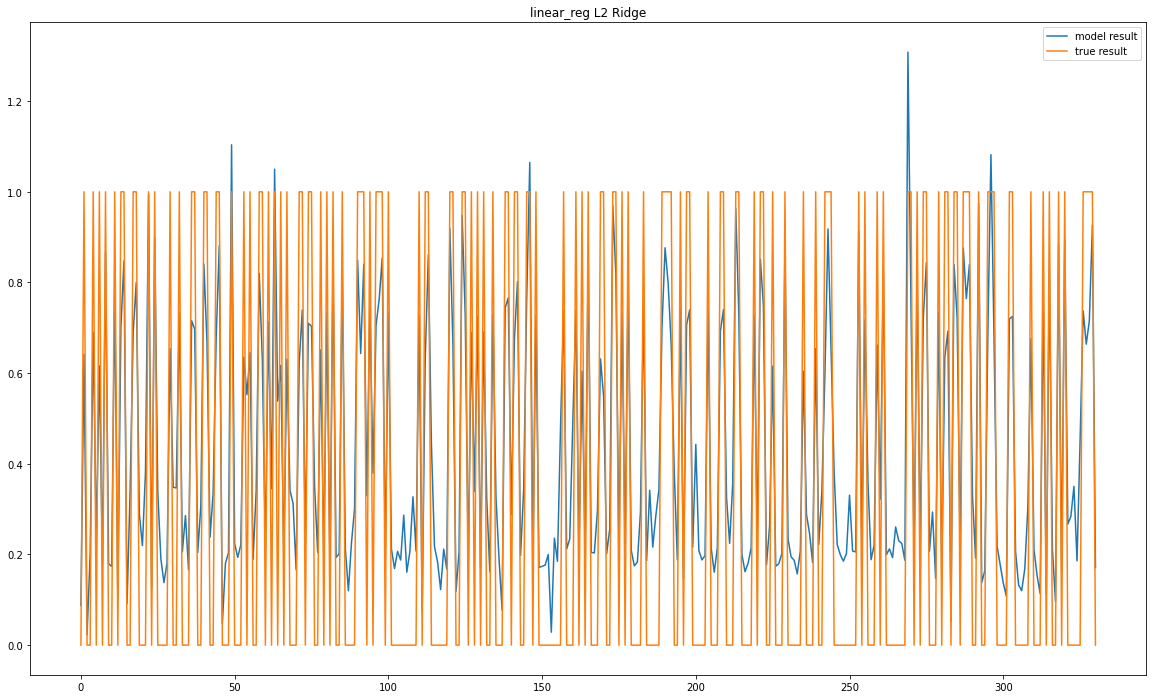

In [5]:
alfa_coef = 3
linear_reg_Ridge(y_train, X_train, y_test, X_test, alfa_coef, 0.4)

После просмотра результатов и весов признаков мы видим, что использование L1 и L2 регуляризации не имеет смысла в данной задаче. Без регуляризации веса не имели огромные значения. После регуляризации и добавления штрафов на веса, мы не получили улучшения значения score.

### Линейная регрессия с генерируемыми признаками

Добавим рандомные признаки в данные:

In [6]:
from random import randrange
from sklearn.preprocessing import MinMaxScaler

global_var_pow = 1
def power_apply(x):
    return x**global_var_pow


new_factors_train = pd.DataFrame(np.random.randint(0, 10, size=(len(X_train), 1)), columns=['x1'])
new_factors_test = pd.DataFrame(np.random.randint(0, 10, size=(len(X_test), 1)), columns=['x1'])

factor_list = ['x1','x2','x3','x4']
a = iter(factor_list)
for i in a:
    X_train[i] = new_factors_train['x1'].apply(power_apply)
    X_test[i] = new_factors_test['x1'].apply(power_apply)
    global_var_pow += 1
    

# Нормализация
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train,), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test,), columns=X_test.columns)    
    
    
X_train.head(5)

Sex       Age  SibSp  Parch      Fare  is_S  is_C  is_Q        x1  \
0  1.0  0.271174    0.2    0.0  0.014151   1.0   0.0   0.0  1.000000   
1  0.0  0.472229    0.2    0.0  0.139136   0.0   1.0   0.0  0.888889   
2  0.0  0.321438    0.0    0.0  0.015469   1.0   0.0   0.0  0.444444   
3  0.0  0.434531    0.2    0.0  0.103644   1.0   0.0   0.0  0.777778   
4  1.0  0.434531    0.0    0.0  0.015713   1.0   0.0   0.0  0.222222   

         x2        x3        x4  
0  1.000000  1.000000  1.000000  
1  0.790123  0.702332  0.624295  
2  0.197531  0.087791  0.039018  
3  0.604938  0.470508  0.365950  
4  0.049383  0.010974  0.002439

Будем оценить веса и результат с 'x1','x2','x3','x4', удаляя постепенно каждый признак x[i].

#### Учитываем 'x1','x2','x3','x4'

Score linear_reg_Simple: 0.723248919257715
Weight vector: [-0.5189372  -0.24616447 -0.2450282  -0.15731933  0.83568267 -0.18539214
 -0.08165259 -0.29828154 -0.43738613 -0.47879687  2.6226871  -1.86325901]
Limit: 0.4
Accuracy score: 0.972809667673716
Precision score: 0.9338235294117647


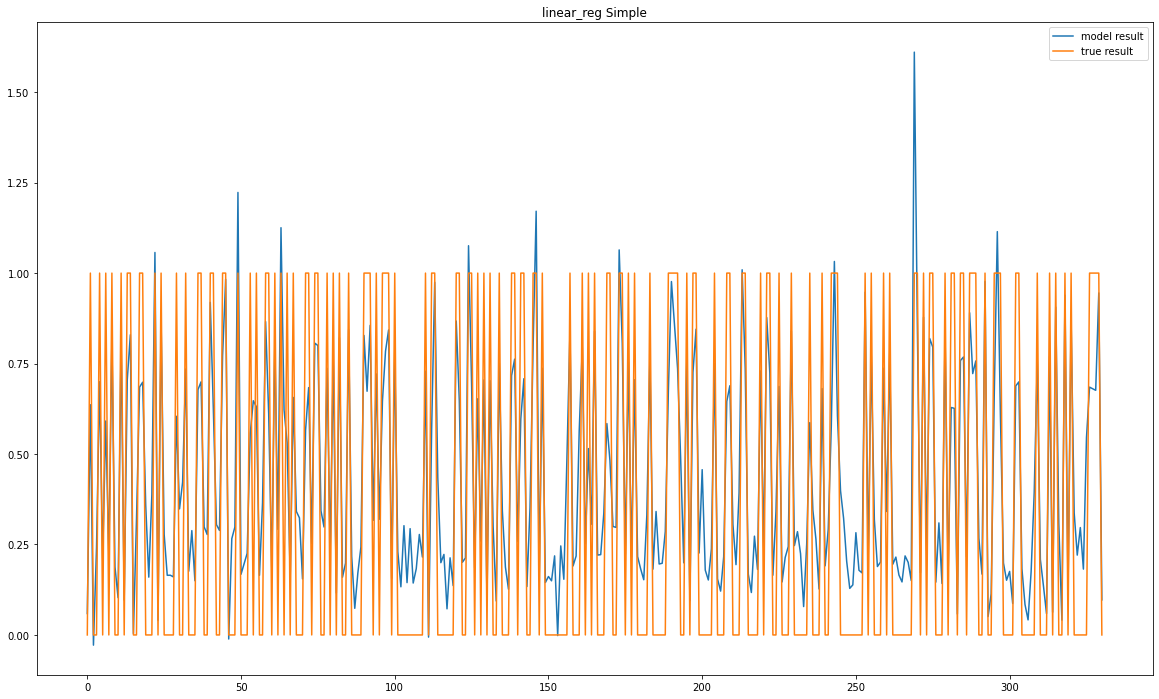

Score L1 Lasso: -0.0021364159949219808
Weight vector: [-0. -0. -0.  0.  0. -0.  0. -0. -0. -0. -0. -0.]
Limit: 0.4
Accuracy score: 0.38368580060422963
Precision score: 0.38368580060422963


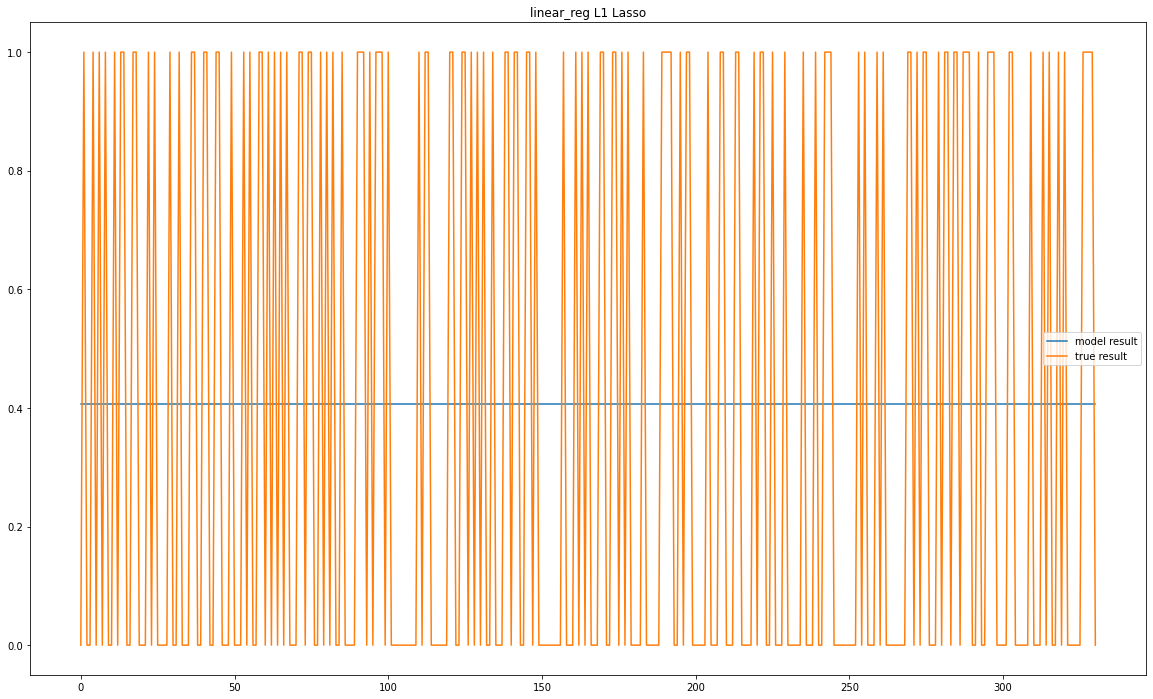

Score L2 Ridge: 0.7356482220827194
Weight vector: [-0.51251115 -0.16298629 -0.17742531 -0.09005087  0.47102539 -0.04111809
  0.09112808 -0.13375563 -0.12369383  0.04397842  0.03385831 -0.02724938]
Limit: 0.4
Accuracy score: 0.9788519637462235
Precision score: 0.9477611940298507


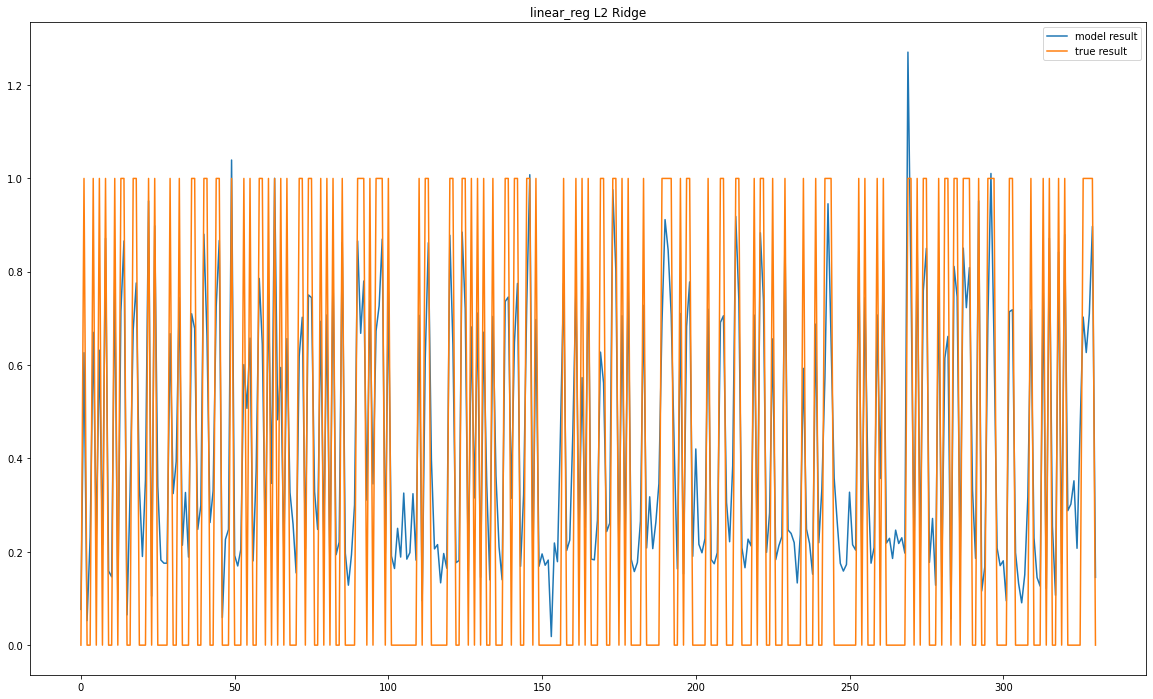

In [7]:
linear_reg_Simple(y_train, X_train, y_test, X_test, 0.4)

alfa_coef = 5

linear_reg_Lasso(y_train, X_train, y_test, X_test, alfa_coef, 0.4)

linear_reg_Ridge(y_train, X_train, y_test, X_test, alfa_coef, 0.4)

#### Учитываем 'x1','x2','x3'

Score linear_reg_Simple: 0.7255720119794654
Weight vector: [-0.51939087 -0.2451791  -0.24350362 -0.16039048  0.83612646 -0.17858917
 -0.0735464  -0.2871491  -0.89743126  1.84187994 -1.10116502]
Limit: 0.4
Accuracy score: 0.9697885196374623
Precision score: 0.927007299270073


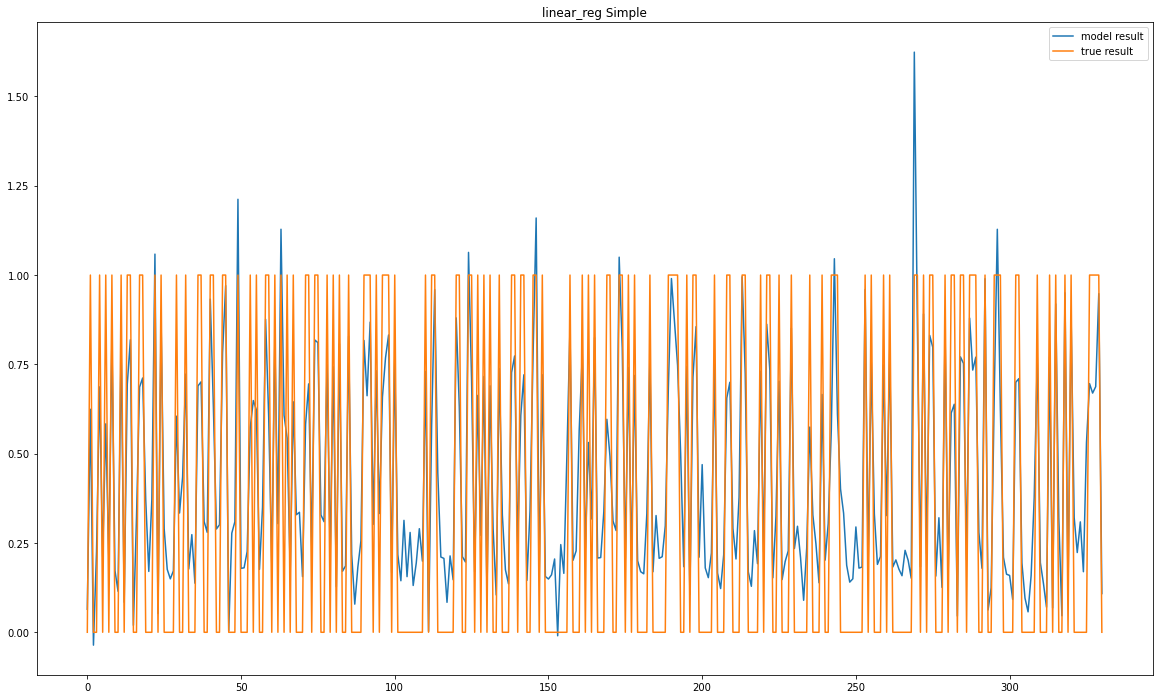

Score L1 Lasso: -0.0021364159949219808
Weight vector: [-0. -0. -0.  0.  0. -0.  0. -0. -0. -0. -0.]
Limit: 0.4
Accuracy score: 0.38368580060422963
Precision score: 0.38368580060422963


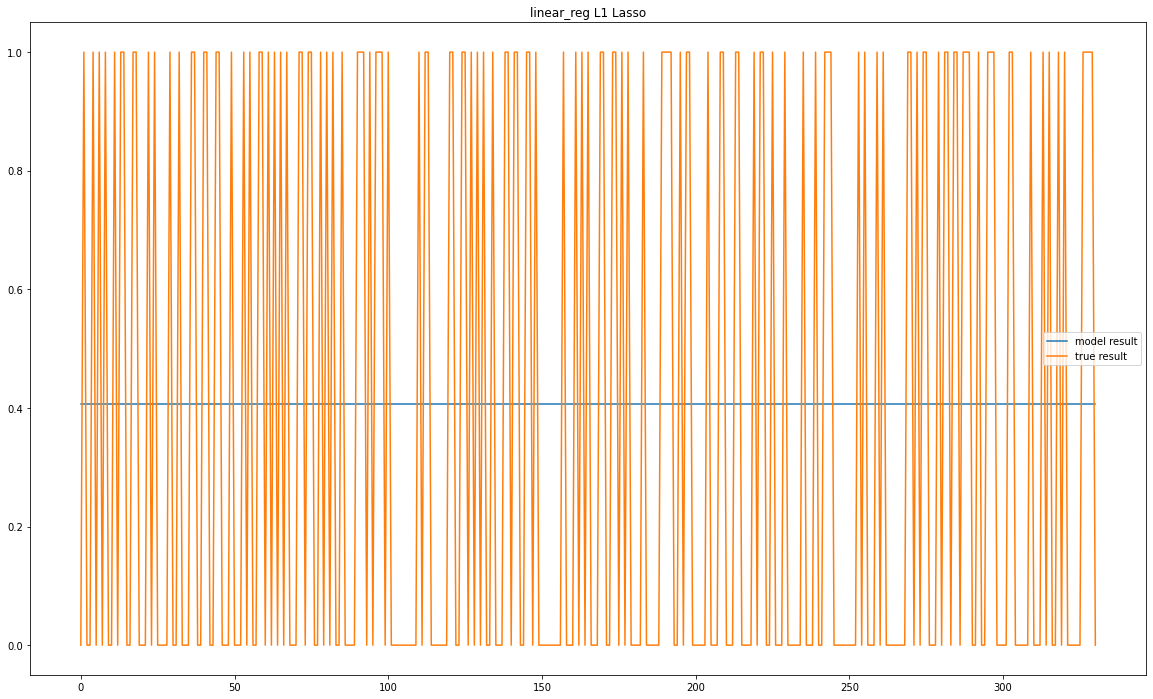

Score L2 Ridge: 0.735936711816594
Weight vector: [-0.51260406 -0.16313635 -0.17746871 -0.08988172  0.47158174 -0.0411445
  0.09098254 -0.13375575 -0.1207272   0.03460265  0.01521498]
Limit: 0.4
Accuracy score: 0.9788519637462235
Precision score: 0.9477611940298507


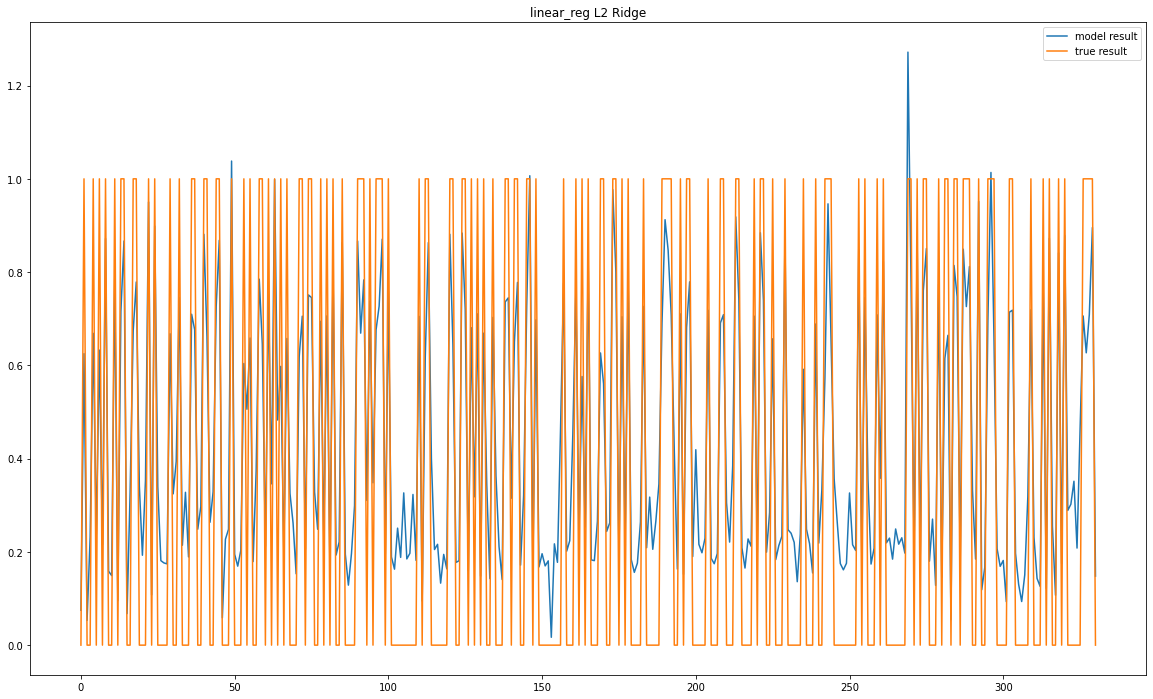

In [8]:
X_train = X_train.drop(['x4'], axis='columns')
X_test = X_test.drop(['x4'], axis='columns')

linear_reg_Simple(y_train, X_train, y_test, X_test, 0.4)

alfa_coef = 5

linear_reg_Lasso(y_train, X_train, y_test, X_test, alfa_coef, 0.4)

linear_reg_Ridge(y_train, X_train, y_test, X_test, alfa_coef, 0.4)

#### Учитываем 'x1','x2'

Score linear_reg_Simple: 0.7280246286437126
Weight vector: [-0.51987373 -0.25338186 -0.24758008 -0.16490677  0.86034368 -0.20943773
 -0.10671777 -0.31881269 -0.27437494  0.19025974]
Limit: 0.4
Accuracy score: 0.9758308157099698
Precision score: 0.9407407407407408


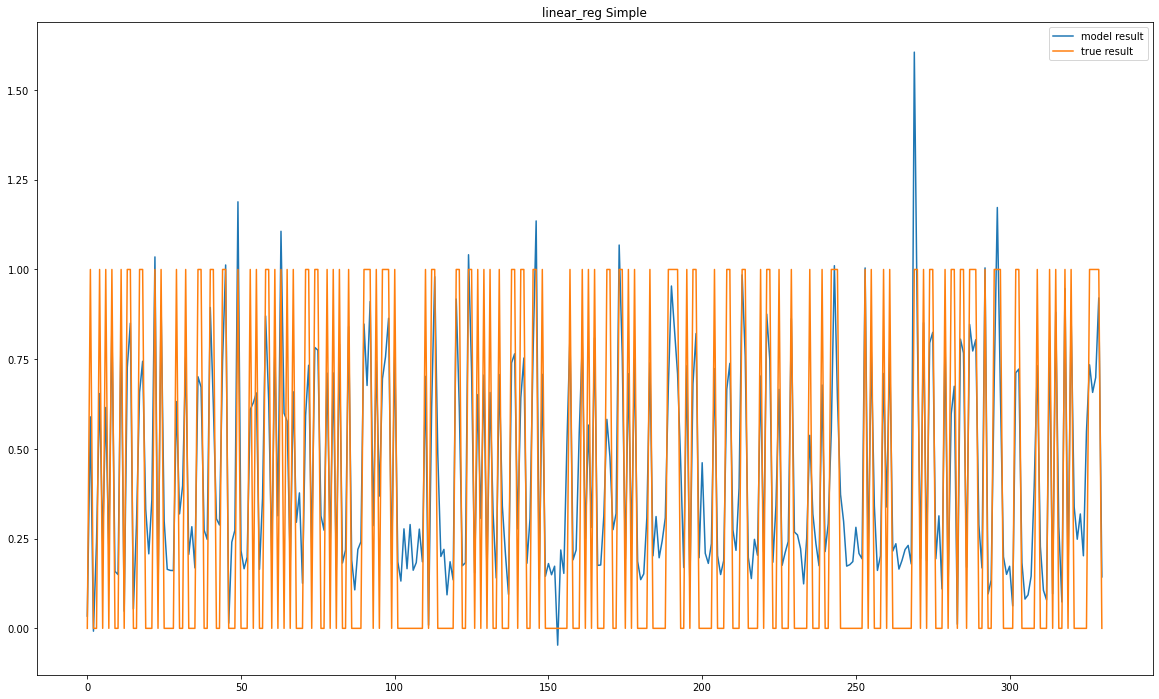

Score L1 Lasso: -0.0021364159949219808
Weight vector: [-0. -0. -0.  0.  0. -0.  0. -0. -0. -0.]
Limit: 0.4
Accuracy score: 0.38368580060422963
Precision score: 0.38368580060422963


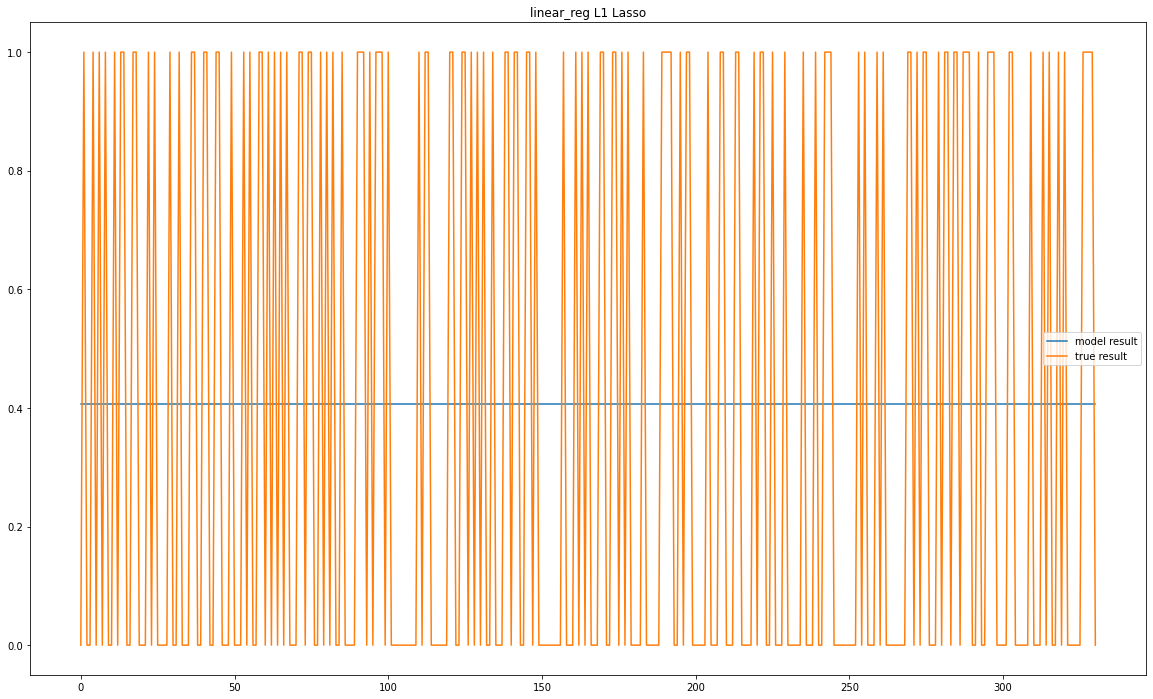

Score L2 Ridge: 0.7356750655083575
Weight vector: [-0.5125311  -0.16309145 -0.17742366 -0.09012752  0.47130739 -0.04117181
  0.09105751 -0.13378005 -0.11955096  0.04751785]
Limit: 0.4
Accuracy score: 0.9788519637462235
Precision score: 0.9477611940298507


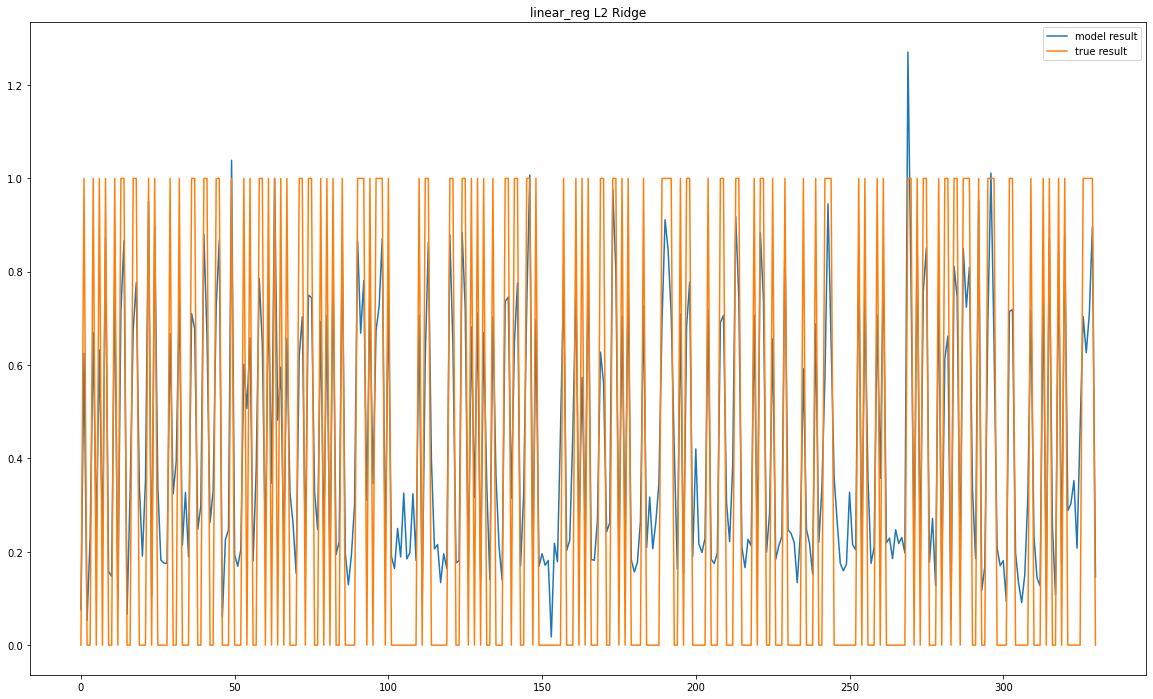

In [9]:
X_train = X_train.drop(['x3'], axis='columns')
X_test = X_test.drop(['x3'], axis='columns')

X_train.head(4)

linear_reg_Simple(y_train, X_train, y_test, X_test, 0.4)

alfa_coef = 5

linear_reg_Lasso(y_train, X_train, y_test, X_test, alfa_coef, 0.4)

linear_reg_Ridge(y_train, X_train, y_test, X_test, alfa_coef, 0.4)

#### Учитываем 'x1'

Score linear_reg_Simple: 0.723961270932753
Weight vector: [-0.51881966 -0.25402657 -0.24693019 -0.17232106  0.85729518 -0.21740052
 -0.1129361  -0.32704638 -0.08481974]
Limit: 0.4
Accuracy score: 0.9758308157099698
Precision score: 0.9407407407407408


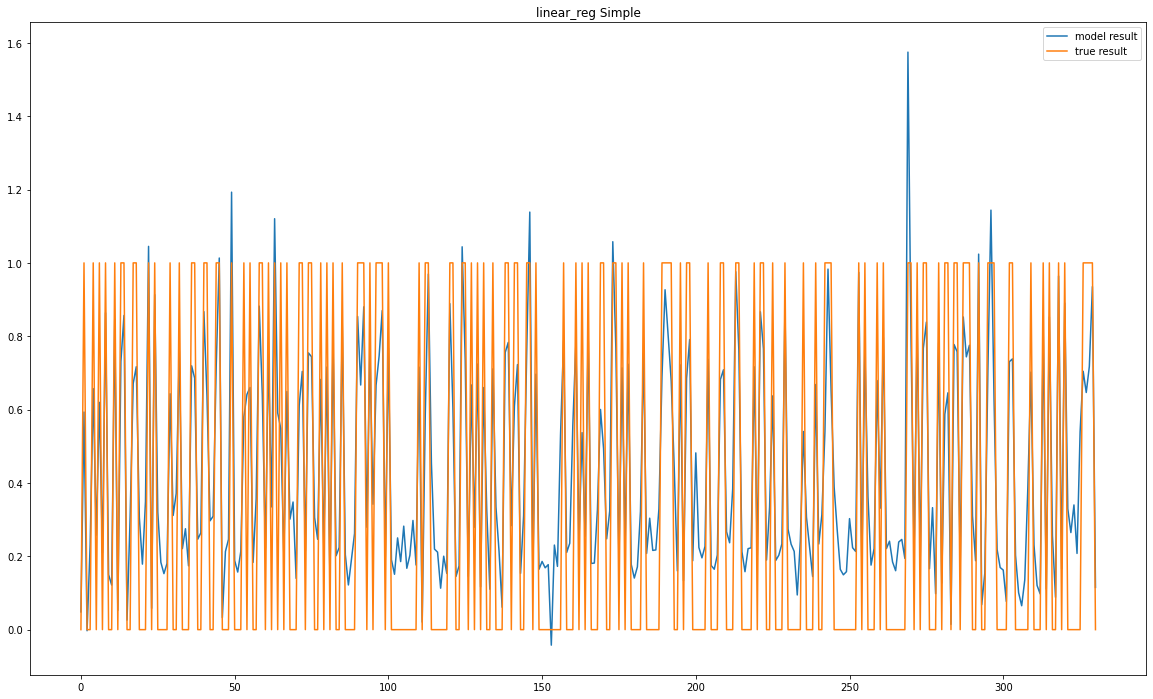

Score L1 Lasso: -0.0021364159949219808
Weight vector: [-0. -0. -0.  0.  0. -0.  0. -0. -0.]
Limit: 0.4
Accuracy score: 0.38368580060422963
Precision score: 0.38368580060422963


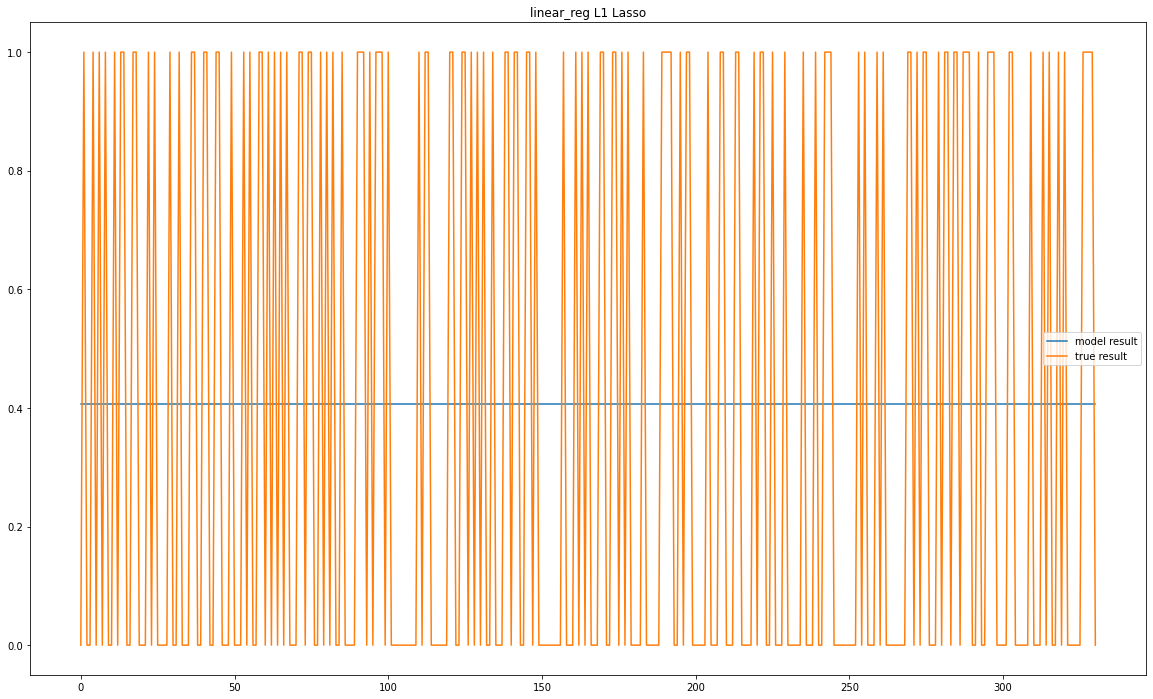

Score L2 Ridge: 0.734184881109005
Weight vector: [-0.51219332 -0.16340173 -0.1770507  -0.09159935  0.47112348 -0.04140008
  0.09117251 -0.13419118 -0.07530243]
Limit: 0.4
Accuracy score: 0.9788519637462235
Precision score: 0.9477611940298507


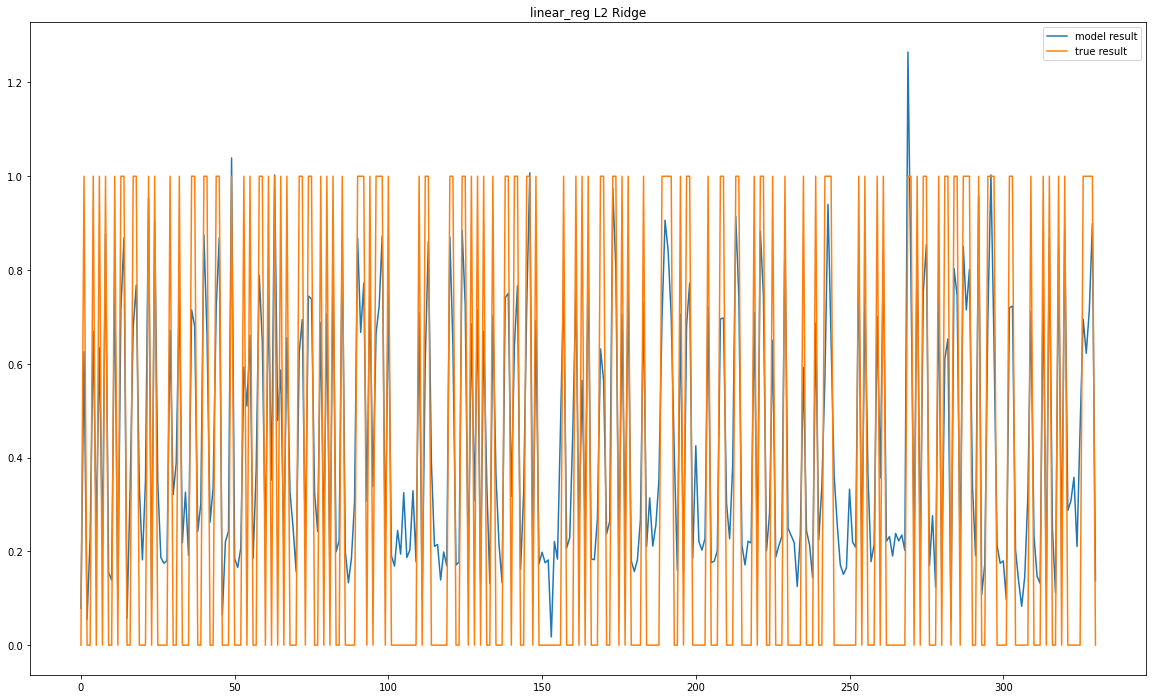

In [10]:
X_train = X_train.drop(['x2'], axis='columns')
X_test = X_test.drop(['x2'], axis='columns')

X_train.head(4)

linear_reg_Simple(y_train, X_train, y_test, X_test, 0.4)

alfa_coef = 5

linear_reg_Lasso(y_train, X_train, y_test, X_test, alfa_coef, 0.4)

linear_reg_Ridge(y_train, X_train, y_test, X_test, alfa_coef, 0.4)

# clear data
X_train = X_train.drop(['x1'], axis='columns')
X_test = X_test.drop(['x1'], axis='columns')

### Отбор признаков с помощью L1 регуляризации, подобрать оптимального С

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=6, shuffle=True, random_state=2)
accuracy = []
C_list = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]


for i in range(0, len(C_list)):
    clf = LogisticRegression(penalty='l1', C=C_list[i], random_state=2, solver='liblinear')
    current_score = cross_val_score(clf, X_train, y_train, cv=kfold).mean()
    accuracy.append(current_score)
    print('При С=', C_list[i], 'точность равна:', current_score)
    
max_score = 0
c_for_max_score = 0
for i in range(0, len(accuracy)):
    if max_score < accuracy[i]:
        max_score = accuracy[i]
        c_for_max_score = i
        
print('\n')
print('Максимальная точность равна:', max_score, 'она получена при С:',  C_list[c_for_max_score])



При С= 1e-05 точность равна: 0.5938375350140056
При С= 0.0001 точность равна: 0.5938375350140056
При С= 0.001 точность равна: 0.5938375350140056
При С= 0.01 точность равна: 0.5938375350140056
При С= 0.1 точность равна: 0.7801120448179272
При С= 1 точность равна: 0.7759103641456583
При С= 10 точность равна: 0.7773109243697479
При С= 100 точность равна: 0.7801120448179272
При С= 1000 точность равна: 0.7801120448179272


/home/alex/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


При С= 10000 точность равна: 0.7801120448179272


/home/alex/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


При С= 100000 точность равна: 0.7801120448179272


Максимальная точность равна: 0.7801120448179272 она получена при С: 0.1


## Вывод

Мы обучили логистическую регрессию на наших данных. Для работы мы использовали LinearRegression, Lasso, Ridge. Для определения логического да/нет на вопрос о выживании пассажира мы использовали порог 0.4. Для логиcтической регрессии оптимальный С = 0.1. Отметим, что изначально веса у признаков были небольшие ([-0.52043688 -0.24698209 -0.25962852 -0.16473417  0.84280781 -0.22964303 -0.12299286 -0.33360824]). Добавление штрафов для весов не дало ожидаемых результатов.